# 19기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from kneed import KneeLocator, DataGenerator

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [1]:
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. EDA

데이터 수: 200

평균 나이: 38.85

평균 연봉: 60.5

In [4]:
df.describe() 

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [14]:
df.info() # 결측치 없음.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [16]:
df.duplicated().sum() # 중복치 없음

0

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

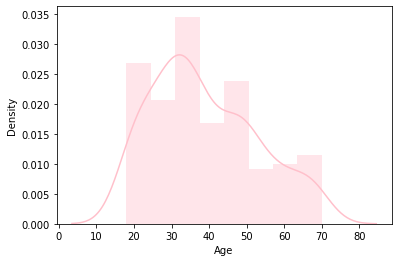

In [20]:
# 나이 분포: 30~40세가 가장 많음
sns.distplot(df['Age'], color='pink')

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Density'>

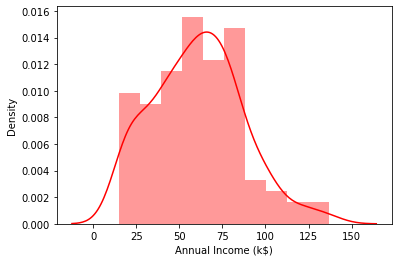

In [22]:
# 수입 분포
sns.distplot(df['Annual Income (k$)'], color='red')

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Density'>

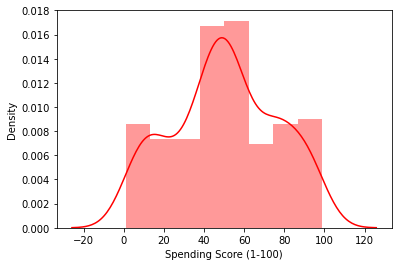

In [23]:
# 지출 분포
sns.distplot(df['Spending Score (1-100)'], color='red')

In [29]:
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [33]:
df.groupby('Gender').count()

,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,
Female,112,112,112
Male,88,88,88


([<matplotlib.patches.Wedge at 0x1ffc6a6bdc0>,
 [Text(-0.20611945413751356, 1.080515974257694, 'Male'),
  Text(0.20611945413751367, -1.080515974257694, 'Female')],
 [Text(-0.11242879316591647, 0.5893723495951058, '56.0%'),
  Text(0.11242879316591654, -0.5893723495951058, '44.0%')])

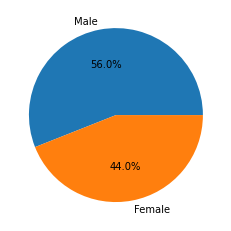

In [36]:
plt.pie(df.groupby('Gender').count()['Age'], labels=['Male', 'Female'], autopct='%.1f%%') 
# Male: 56%, Female: 44%

In [13]:
df.corr()

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


<AxesSubplot:>

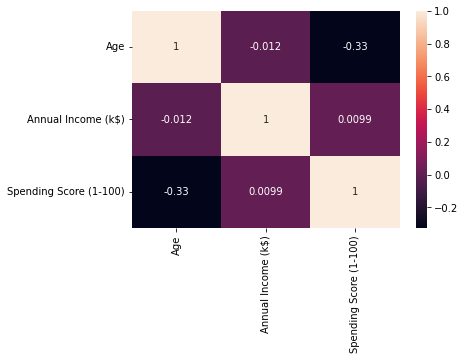

In [17]:
# 상관계수 히트맵: 나이와 지출은 반비례하는 것으로 나타남.
sns.heatmap(df.corr(), annot = True)

## 2. Clustering

In [41]:
x = df[["Age", "Annual Income (k$)", "Spending Score (1-100)"]]
scaled_x = StandardScaler().fit_transform(x) # normalize 진행

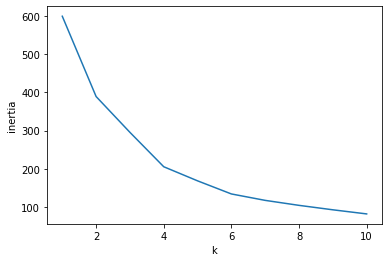

In [50]:
inertia = list()

K = range(1, 11)

for k in K:
    model = KMeans(n_clusters=k)
    model.fit(scaled_x)
    inertia.append(model.inertia_)

plt.xlabel('k')
plt.ylabel('inertia')
plt.plot(K, inertia)

In [52]:
model = KMeans(n_clusters=4)
predict = model.fit_predict(scaled_x)
df['cluster'] = predict
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
CustomerID,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,1
4,Female,23,16,77,1
5,Female,31,17,40,1


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='component 0', ylabel='component 1'>

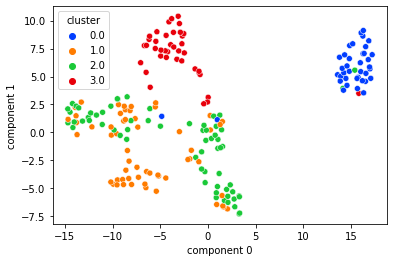

In [63]:
tsne_df  = pd.DataFrame(TSNE(n_components=2).fit_transform(scaled_x), columns = ['component 0', 'component 1'])
tsne_df['cluster'] = df['cluster']

sns.scatterplot(tsne_df['component 0'], tsne_df['component 1'], hue=tsne_df.cluster, legend='full', palette= sns.color_palette("bright", 4))